In [ ]:
!git clone https://github.com/fastmachinelearning/hls4ml-tutorial

In [ ]:
!cd hls4ml-tutorial

In [ ]:
pip install --upgrade pip

In [ ]:
pip install notebook

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

In [ ]:
!python -m venv /home/jovyan/.local/share/jupyter/kernels/.venv_hls4ml


In [ ]:
!pip install ipykernel


In [ ]:
!python -m ipykernel install --user --name=.venv_hls4ml --display-name "Python (.venv_hls4ml)"


In [ ]:
import sys
print(sys.executable)


In [ ]:
!pip install hls4ml[profiling]

In [ ]:
!pip install scikit-learn pydot graphviz

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin/vivado' + os.environ['PATH']

In [ ]:
!which vivado


## Fetch the jet tagging dataset from Open ML

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Let's print some information about the dataset
# Print the feature names and the dataset shape

In [ ]:
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [ ]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)


## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [21]:
pip install tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import *

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define a more regularized model with Dropout layers
def create_regularized_model(input_dim=30):  # Breast cancer dataset has 30 features
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))  # Drop 50% of the units
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))  # Drop 50% of the units
    model.add(Dense(1, activation='sigmoid'))
    return model

# Initialize the model
model = create_regularized_model(input_dim=X_train.shape[1])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath='best_regularized_model_checkpoint.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model with early stopping and checkpointing
history = model.fit(
    X_train,                # Training data
    y_train,                # Training labels
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Epoch 1/50
 1/12 [=>............................] - ETA: 4s - loss: 0.9990 - accuracy: 0.4062
Epoch 1: val_loss improved from inf to 0.55116, saving model to best_regularized_model_checkpoint.h5
12/12 [==============================] - 1s 12ms/step - loss: 0.9072 - accuracy: 0.4093 - val_loss: 0.5512 - val_accuracy: 0.7143
Epoch 2/50
 1/12 [=>............................] - ETA: 0s - loss: 0.7542 - accuracy: 0.5625
Epoch 2: val_loss improved from 0.55116 to 0.42447, saving model to best_regularized_model_checkpoint.h5
12/12 [==============================] - 0s 6ms/step - loss: 0.6086 - accuracy: 0.6401 - val_loss: 0.4245 - val_accuracy: 0.9670
Epoch 3/50
 1/12 [=>............................] - ETA: 0s - loss: 0.4989 - accuracy: 0.7812
Epoch 3: val_loss improved from 0.42447 to 0.32753, saving model to best_regularized_model_checkpoint.h5
12/12 [==============================] - 0s 6ms/step - loss: 0.4668 - accuracy: 0.7747 - val_loss: 0.3275 - val_accuracy: 0.9670
Epoch 4/50
 1/12 [=

In [35]:
model.save('/home/jovyan/hls4ml-tutorial/model_1/hls4ml-tutorial.h5')


## Check performance
Check the accuracy and make a ROC curve

4/4 [==============================] - 0s 1ms/step
Accuracy: 0.9649
Precision: 0.9857
Recall: 0.9583
F1 Score: 0.9718


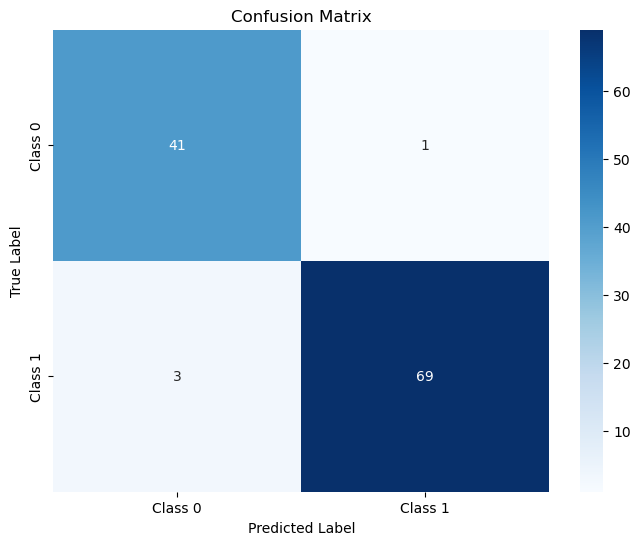

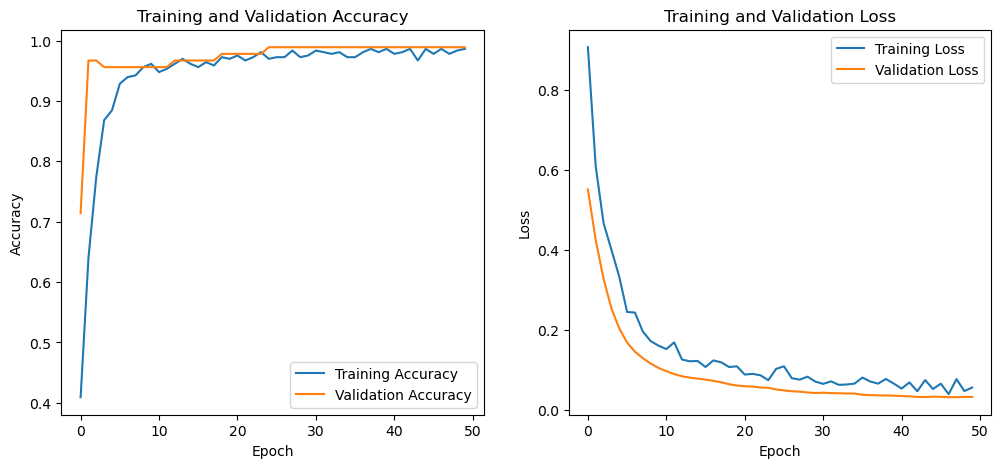

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model if you used checkpointing
best_model = load_model('best_regularized_model_checkpoint.h5')

# Predict on the test set
y_prob = best_model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 2. Learning Curves (Training and Validation Accuracy & Loss)
# Assuming `history` object is available from the training process
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


## Convert the model to FPGA firmware with hls4ml
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
Then we will synthesize the model with Vivado HLS and check the metrics of latency and FPGA resource usage.

### Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [41]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 50.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 49.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 48.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 54.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 56.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 56.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 56.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━

In [47]:
import hls4ml


config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
# plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: dense_6_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: dense_6, layer type: Dense, input shapes: [[None, 30]], output shape: [None, 64]
Layer name: dense_7, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: dense_8, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 1]
-----------------------------------
Configuration
-----------------------------------
Interpreting Sequential
Topology:
Layer name: dense_6_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: dense_6, layer type: Dense, input shapes: [[None, 30]], output shape: [None, 64]
Layer name: dense_7, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: dense_8, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 1]
Creating HLS model


Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

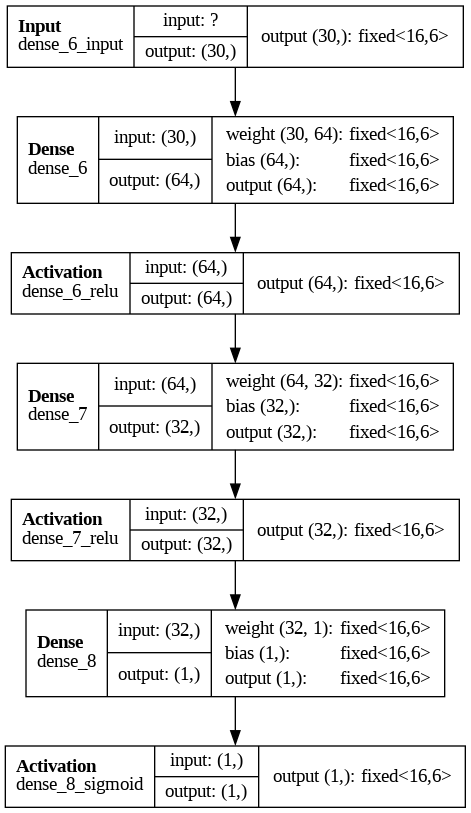

In [48]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [49]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


## Compare
That was easy! Now let's see how the performance compares to Keras:

In [51]:
print("Keras  Accuracy: {}".format(accuracy_score(np.round(y_test), np.round(y_pred))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.round(y_test),  np.round(y_hls))))



Keras  Accuracy: 0.9649122807017544
hls4ml Accuracy: 0.9385964912280702


In [52]:
from sklearn.metrics import classification_report, confusion_matrix
# For Keras Model
print("Keras Model Confusion Matrix:")
print(confusion_matrix(y_test, np.round(y_pred)))

# For hls4ml Model
print("hls4ml Model Confusion Matrix:")
print(confusion_matrix(y_test, np.round(y_hls)))


Keras Model Confusion Matrix:
[[41  1]
 [ 3 69]]
hls4ml Model Confusion Matrix:
[[39  3]
 [ 4 68]]


## Synthesize
Now we'll actually use Vivado HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vivado HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vivado_hls.log`

In [54]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jovyan' on host '9032559deaf2' (Linux_x86_64 version 3.10.0-1160.118.1.el7.x86_64) on Sun Nov 10 02:20:21 UTC 2024
INFO: [HLS 200-10] In directory '/home/jovyan/model_1/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/jovyan/model_1/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [HLS 200-10] Adding test 

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.026',
  'BestLatency': '7',
  'WorstLatency': '7',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '1',
  'DSP': '2956',
  'FF': '13242',
  'LUT': '101104',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [55]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

Found 1 solution(s) in model_1/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sun Nov 10 02:29:42 2024

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.026 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+----------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline |
    |   min   |   max   |    min    |    max    | min | max |   Type   |
    +---------+---------+---

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)